In [26]:
# import torch
# import torch.nn as nn
# import pandas as pd
import numpy as np
import os
# from torch.utils.data import Dataset, DataLoader, random_split
# from torch.nn.utils.rnn import pad_sequence
import copy
import time
# from torch.nn.modules.batchnorm import BatchNorm1d
import matplotlib.pyplot as plt
import scipy

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import pandas as pd

### Define the Structure of the model

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        assert (
            self.head_dim * heads == embed_dim
        ), "Embedding dimension needs to be divisible by heads"

        self.values_linear = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys_linear = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries_linear = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_dim)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values_linear(values)
        keys = self.keys_linear(keys)
        queries = self.queries_linear(query)

        # Get the dot product between queries and keys, and then apply the softmax
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_dim ** (1 / 2)), dim=3)

        # Apply the self attention to the values
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

class TimeSeriesModel(nn.Module):
    def __init__(self, embed_dim, heads, max_length,output_dim=1):
        super().__init__()
        self.self_attention = SelfAttention(embed_dim, heads)
        self.global_pooling = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(embed_dim, output_dim)
        self.pos_encoder = PositionalEncoding(embed_dim,max_length)
        self.batch_norm1 = BatchNorm1d(embed_dim,max_length)
        self.embed_dim = embed_dim
        self.heads = heads
        self.max_length = max_length
        self.output_dim = output_dim
        

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)
        x = self.self_attention(x, x, x)  # Apply self-attention
        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)
        x = x.permute(0, 2, 1)  # Switch dimensions for pooling
        x = self.global_pooling(x).squeeze(2)  # Apply global pooling
        x = self.linear(x)  # Apply final linear layer
        x = x.squeeze()
        return x

### Load the Optimal Model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SelfAttentionModel = TimeSeriesModel(18,2,1)
SelfAttentionModel.to(device)
SelfAttentionModel.load_state_dict(torch.load('Loss_0.8434446156024933.pt',map_location=torch.device(device)))

<All keys matched successfully>

#### Create Dataset

#### necessary function

In [3]:
def ConvertTextToNumpyArray(text): # text array -> numpy array '[1,2,3]' -> [1,2,3]
    # Step 1: Remove the square brackets and extra whitespace
    text_cleaned = text.strip('[]').strip()

    # Step 2: Split the cleaned text by whitespace to get individual integers as strings
    int_strings = text_cleaned.split()


    # Step 3: Convert the strings to integers
    integers = [int(x) for x in int_strings]
    integers

    numpy_array = np.array(integers)
    return numpy_array

def ConvertRowToNumpy(a): # Row with last element is text array -> array with concatenated way [1,4,6,'[1,2,3]'] -> [1,4,6,1,2,3]
    temp = ConvertTextToNumpyArray(a[8])
    ResultedNumpy = np.concatenate((a[0:8],temp),axis=0)
    return ResultedNumpy


def ConvertDataFrameToNumpy(t): # Dataframe -> Numpy array

    # Convert DataFrame To Numpy
    original_array = t.values

    # Use np.vectorize to apply the custom function to each row in the original array
    vectorized_process = np.vectorize(ConvertRowToNumpy, signature='(m)->(n)')

    # Process the entire original array without using an explicit for loop
    final_array = vectorized_process(original_array)
    return final_array

def ConvertCSVToNumpy(CSVPath,p): # CSV Path -> Numpy array
    if os.path.isfile(CSVPath):
        t = pd.read_csv(CSVPath)
        NumpyResult = ConvertDataFrameToNumpy(t)
        return NumpyResult
    else:
        np.zeros(shape=(p,))

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence([seq for seq in sequences], batch_first=True)
    labels = torch.as_tensor(labels)
    return sequences_padded.float(), labels.float()        
        



### Load Necessary Data and Extract Time Series Feature

In [10]:
RootPath = "C:\\Users\\aitry\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel"
PathLoadExcel = os.path.join(RootPath,"VirtFuse data 26072023.xlsx")
t = pd.read_excel(PathLoadExcel)
t

,Date,file name,initial temperature,Unnamed: 3,Catalyst #1: trig93,Catalyst #2: trig524 (2%),Accelerator: cob 6% (max 0.7%),Quality score
0,2023-05-05 00:00:00,192.168.1.64_02_20230505085243583.mp4,18,18,60,420,156,7
1,2023-05-05 00:00:00,192.168.1.64_02_202305050100543584.mp4,20,20,90,390,150,5
2,2023-05-30 00:00:00,192.168.1.64_02_2023053008542479.mp4,19,20,90,390,150,6
3,2023-06-21 00:00:00,192.168.1.64_02_20230621074514667.mp4,20,20,90,390,150,8
4,2023-06-28 00:00:00,192.168.1.64_02_20230628102913672.mp4,25,26,180,300,132,3
5,2023-06-28 00:00:00,192.168.1.64_02_20230628090938483.mp4,22,22,120,360,144,4
6,29/06/2023,192.168.1.64_02_20230629110733693.mp4,27,28,210,270,126,6
7,2023-06-30 00:00:00,192.168.1.64_02_20230630141655536.mp4,30,30,240,240,120,7
8,2023-06-30 00:00:00,192.168.1.64_02_20230630125757199.mp4,30,30,240,240,120,3
9,2023-06-30 00:00:00,192.168.1.64_02_20230630110342551.mp4,27,28,210,270,126,2


In [8]:
PathLoadExcel

'\\DataForAIModel\\VirtFuse data 26072023.xlsx'

In [11]:
# RootPath = "D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel"
# PathLoadExcel = os.path.join(RootPath,"VirtFuse data 26072023.xlsx")


t = pd.read_excel(PathLoadExcel)
# print(t)
type(t['file name'].values)

text = t['file name'].values[10]
# print(text)
def ExtractCSVName(text):
    ## Extract The file name
    temp = text.split(".")[0:-1]
    return '.'.join(temp) + '.csv'

text = ExtractCSVName(text)    
# print(text)
filePath = os.path.join(RootPath,text)


def ExtaractFilePath(RootPath,text):
    text = ExtractCSVName(text)    
    filePath = os.path.join(RootPath,text)
    return filePath


ExtaractFilePath(RootPath,text)

filePath = np.vectorize(ExtaractFilePath, excluded=[RootPath])

FilePathArray = filePath(RootPath=RootPath,text = t['file name'].values)


## Check Number OF Missing
def isFile(filePath):
    return os.path.isfile(filePath)
CheckFile = np.vectorize(isFile)
index = np.where(CheckFile(FilePathArray))
FilePathArray = FilePathArray[index]     
a = zip(FilePathArray,t['Quality score'].values[index])
dictionary = {k:v for k,v in a}
dictionary

{'C:\\Users\\aitry\\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel\\192.168.1.64_02_20230505085243583.csv': 7,
 'C:\\Users\\aitry\\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel\\192.168.1.64_02_2023053008542479.csv': 6,
 'C:\\Users\\aitry\\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel\\192.168.1.64_02_20230628102913672.csv': 3,
 'C:\\Users\\aitry\\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel\\192.168.1.64_02_20230628090938483.csv': 4,
 'C:\\Users\\aitry\\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel\\192.168.1.64_02_20230629110733693.csv': 6,
 'C:\\Users\\aitry\\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel\\192.168.1.64_02_20230630141655536.csv': 7,
 'C:\\Users\\aitry\\OneDrive\\Desktop\\KyKlosCodes\\virtfuse\\Backend\\AIcodes\\DataForAIModel\\192.168.1.64_02_20230630125757199.csv': 3,
 'C:\\Users\\aitry\\OneDrive

In [21]:
intialTempratures = t["initial temperature"].values[index]
catalistResinRatios1 = t["Catalyst #1: trig93"].values[index]
catalistResinRatios2 = t["Catalyst #2: trig524 (2%)"].values[index]
TrueScore = t["Quality score"].values[index]

In [13]:
def ExtractX(CSVPath,p):
    X = ConvertCSVToNumpy(CSVPath,p)
    return X
    

VectorizedX = np.vectorize(ExtractX,excluded=['p'])    
InputFeature  = VectorizedX(CSVPath = FilePathArray,p=18)  

In [14]:
InputFeature.dtype

dtype('O')

### Create Tensor Database

In [23]:
class VariableLengthSequenceDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.target[idx])

In [24]:
XData = [torch.tensor(InputFeature[i][30:1030].astype(float)) for i in np.arange(InputFeature.shape[0])]
YData = torch.tensor(t['Quality score'].values[index])

In [25]:
dataset = VariableLengthSequenceDataset(XData,YData)
# dataloader = DataLoader(dataset, batch_size=3)

### Create Numpy Version Of Estimated Scores

In [16]:
XDataNumpy = [InputFeature[i][30:1030].astype(float) for i in np.arange(InputFeature.shape[0])]

In [33]:
InputFeature.shape

(34,)

In [9]:
def ScoreEstimation(InputTimeSeriesFeature,device,Estimator):
    ## Extraction of Critical Point
    index = 30# 👈 t should be extracted from input series  
    Length = 1000# 👈 It should be changed  
    ## Estimation
    Estimator1 = copy.deepcopy(Estimator)
    input = torch.tensor(InputTimeSeriesFeature[index:index+Length].astype(float)).to(device).float()
    Estimator1.eval()
    target = Estimator1(input)
    return target.cpu().detach().numpy()

A = InputFeature[1][31:1031]

# t = ScoreEstimation(A,device,SelfAttentionModel)
# print(t)
# print(type(t))
# print(t.shape)

ScoreEstimator = np.vectorize(ScoreEstimation,excluded=["device","Estimator"])

YEstimated = ScoreEstimator(InputTimeSeriesFeature = InputFeature ,device=device,Estimator = SelfAttentionModel)

print(YEstimated)
print(YEstimated.shape)

[5.473279  4.62019   4.3532295 4.4303093 4.3626795 4.562708  4.448206
 4.613574  4.580658  4.602677  4.4074783 4.660562  4.292363  4.3666935
 4.486662  4.6144238 4.536565  4.5100527 4.394993  4.4273586 4.5133457
 4.4949064 4.3560605 4.511612  4.606989  4.4660873 4.412787  4.451852
 4.359679  4.5189524 4.6661525 4.983576  4.378951  4.6421013]
(34,)


### Total Rsquared Error

In [16]:
MSE =  np.linalg.norm((YEstimated-TrueScore))/TrueScore.shape[0]
Var = np.var(TrueScore)
Rsquared = 1 - MSE/Var

### Bayesian Optimization

#### Determine the optimization space

In [15]:
TempratureMax = np.max(intialTempratures)
TempratureMin = np.min(intialTempratures)

ResinMax = np.max(catalistResinRatios1)
ResinMin = np.min(catalistResinRatios1)

Resin1Max = np.max(catalistResinRatios2)
Resin1Min = np.min(catalistResinRatios2)


#### Plot Real Points of Initial Tempratures and Resin Ratio and Score   

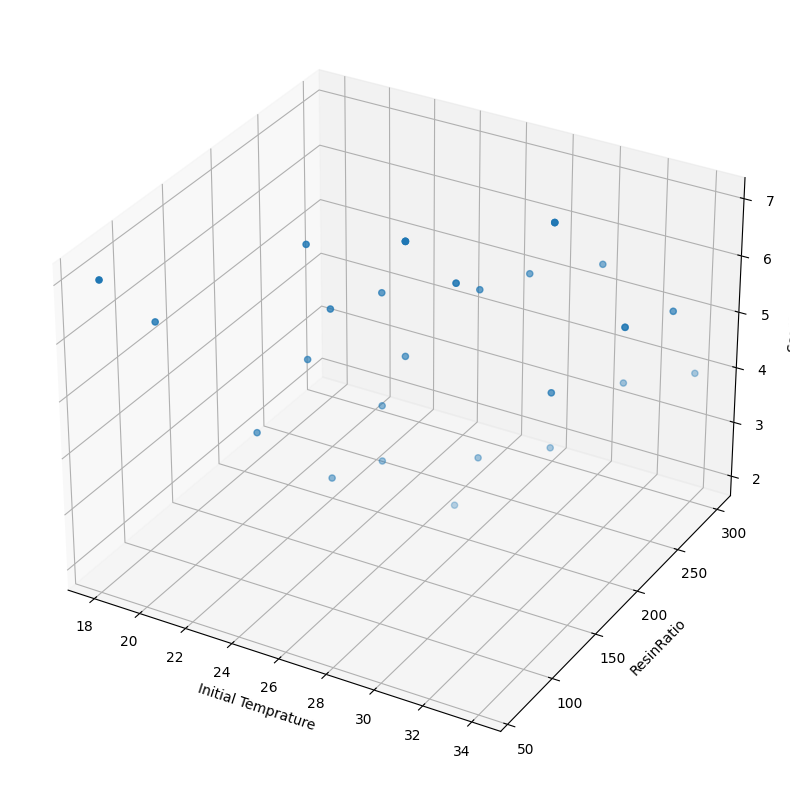

In [16]:
fig = plt.figure(figsize=(10,10))

# Create 3D axis
ax = fig.add_subplot(111, projection='3d')

ax.scatter(intialTempratures, catalistResinRatios1, TrueScore)

# Labels for the axes
ax.set_xlabel('Initial Temprature')
ax.set_ylabel('ResinRatio')
ax.set_zlabel('Score')

plt.show()

#### Rescaled InputSpace

In [11]:
ResclaedTemprature = (intialTempratures - TempratureMin)/(TempratureMax-TempratureMin)

In [12]:
ResclaedResinRatio = (catalistResinRatios1 - ResinMin)/(ResinMax-ResinMin)

In [17]:
# Mesh the input space for evaluations of the real function, the prediction and
# its standard deviation
x = np.linspace(TempratureMin,TempratureMax, 50)
y = np.linspace(Resin1Min,Resin1Max, 50)
x, y = np.meshgrid(x, y)
X = np.vstack([x.ravel(), y.ravel()]).T

In [34]:
x[0][1:-1] - x[0][0:-2]

array([0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.32653061, 0.32653061])

In [24]:
X_sample = np.zeros(shape=(intialTempratures.shape[0],2))
# X_sample[:,0] = ResclaedTemprature
X_sample[:,0] = intialTempratures
# X_sample[:,1] = ResclaedResinRatio
X_sample[:,1] = catalistResinRatios1 

In [23]:
TrueScore

array([7, 6, 3, 4, 6, 7, 3, 2, 7, 6, 5, 5, 4, 5, 4, 6, 7, 4, 5, 5, 6, 7,
       3, 4, 5, 6, 6, 7, 3, 6, 7, 7, 5, 4], dtype=int64)

In [27]:
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_sample, TrueScore)


# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred1, sigma = gp.predict(X, return_std=True)

AttributeError: 'str' object has no attribute 'decode'

In [21]:
y_pred1.reshape

<function ndarray.reshape>

In [27]:
gp1 = copy.deepcopy(gp)

In [67]:
import pickle
with open('my_object.pkl', 'wb') as f:
    pickle.dump(gp1, f)

In [4]:
import pickle
with open('my_object.pkl', 'rb') as f:
    loaded_object = pickle.load(f)
print(loaded_object)

TypeError: __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given

In [73]:
y_pred4, sigma = loaded_object.predict(X, return_std=True)

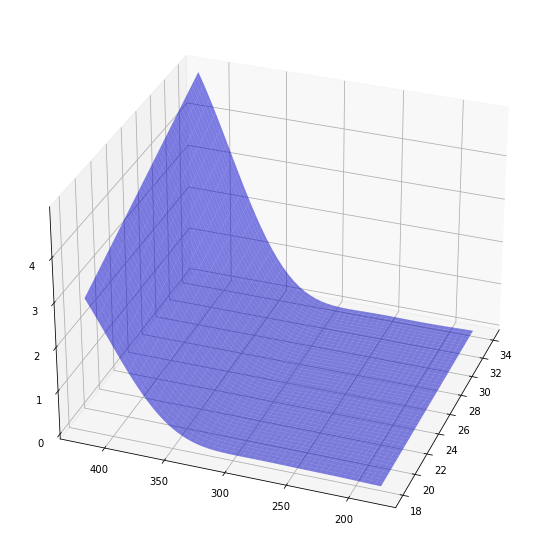

In [74]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, y_pred4.reshape(x.shape)/1000, color='b', alpha=0.5)
ax.view_init(azim=200)

#### Plot Real Data and Estimated Guassian Process

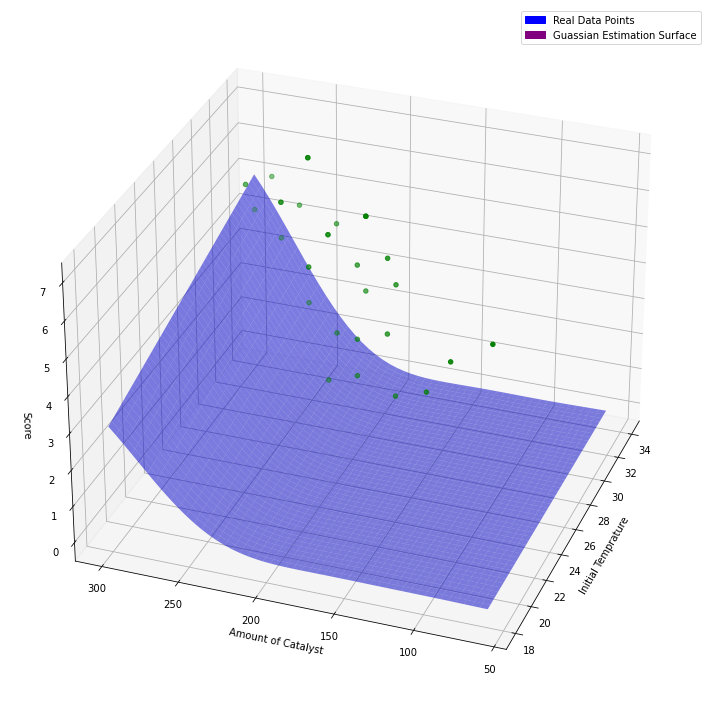

In [66]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10,10))

# Create 3D axis
ax = fig.add_subplot(111, projection='3d')

ax.scatter(intialTempratures, catalistResinRatios2,TrueScore, color='g', label = "Real Data" )
ax.plot_surface(x, y, y_pred1.reshape(x.shape)/1000, color='b', alpha=0.5)


# Create proxy artists for the legend

# Labels for the axes
ax.set_xlabel('Initial Temprature')
ax.set_ylabel('Amount of Catalyst')
ax.set_zlabel('Score')

ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.zaxis.set_label_coords(-0.1, 0.5)
ax.view_init(azim=200)

scatter_proxy = mpatches.Patch(color='blue', label='Real Data Points')
surface_proxy = mpatches.Patch(color='purple', label='Guassian Estimation Surface')
ax.legend(handles=[scatter_proxy, surface_proxy])

# ax.view_init(azim=10,vertical_axis='x')
plt.tight_layout()

plt.show()

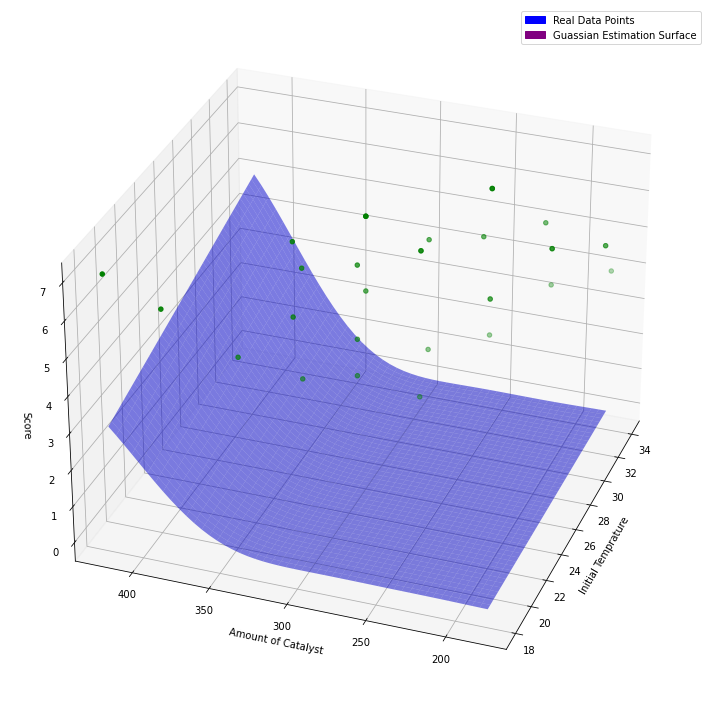

In [75]:
fig = plt.figure(figsize=(10,10))

# Create 3D axis
ax = fig.add_subplot(111, projection='3d')

ax.scatter(intialTempratures, catalistResinRatios2,TrueScore, color='g', label = "Real Data" )
ax.plot_surface(x, y, y_pred1.reshape(x.shape)/1000, color='b', alpha=0.5)


# Create proxy artists for the legend

# Labels for the axes
ax.set_xlabel('Initial Temprature')
ax.set_ylabel('Amount of Catalyst')
ax.set_zlabel('Score')

ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.zaxis.set_label_coords(-0.1, 0.5)
ax.view_init(azim=200)

scatter_proxy = mpatches.Patch(color='blue', label='Real Data Points')
surface_proxy = mpatches.Patch(color='purple', label='Guassian Estimation Surface')
ax.legend(handles=[scatter_proxy, surface_proxy])

# ax.view_init(azim=10,vertical_axis='x')
plt.tight_layout()

plt.show()

In [76]:
def EstimatorResinRatio(Temprature,gpLearned,TempratureMin,TempratureMax,ResinMin,ResinMax):
    gpLearnedCopy = copy.deepcopy(gpLearned)
    x = np.linspace(TempratureMin,TempratureMax, 50)
    y = np.linspace(ResinMin,ResinMax, 50)
    x, y = np.meshgrid(x, y)
    X = np.vstack([x.ravel(), y.ravel()]).T

    index = np.where(np.abs(x[0]-Temprature)<np.abs(x[0][0]-x[0][1])/2)
    index[0][0]

    y_pred1, sigma = gpLearnedCopy.predict(X, return_std=True)

    Yestimation = y_pred1.reshape(x.shape)
    
    ymaxindex = np.argmax(Yestimation[:,index[0][0]])
    
    return y[ymaxindex,index[0][0]]



# EstimatorResinRatio(26,gp=gp1,TempratureMin=TempratureMin,TempratureMax = TempratureMax,ResinMin = ResinMin, ResinMax = ResinMax)

# Temprature = np.linspace(18,30,100)
# ResinRatioEstimatedValues = np.zeros_like(Temprature)

# for i,temp in enumerate(Temprature):
#     ResinRatioEstimatedValues[i] = EstimatorResinRatio(temp,gp=gp1,TempratureMin=TempratureMin,TempratureMax = TempratureMax,ResinMin = ResinMin, ResinMax = ResinMax)

InputTemprature = np.linspace(18,34,100)
ResinRatioEsitmators =  np.vectorize(EstimatorResinRatio,excluded=["gp","TempratureMin","TempratureMax","Resin1Min","Resin1Max"]) 


EstimatedResinRatio = ResinRatioEsitmators(Temprature = InputTemprature ,gpLearned=loaded_object,TempratureMin=TempratureMin,TempratureMax = TempratureMax,ResinMin = ResinMin, ResinMax = ResinMax)

In [ ]:
x = np.linspace(TempratureMin,TempratureMax, 50)
y = np.linspace(ResinMin,ResinMax, 50)
x, y = np.meshgrid(x, y)
X = np.vstack([x.ravel(), y.ravel()]).T


# Fit to data using Maximum Likelihood Estimation of the parameters
gp1.fit(X_sample, TureScore)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred1, sigma = gp1.predict(X, return_std=True)


fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, y_pred1.reshape(x.shape)/1000, color='b', alpha=0.5)




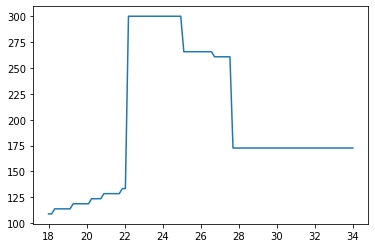

In [77]:
plt.plot(InputTemprature,EstimatedResinRatio)

#### MSE on catalyst Resin Ratio

In [78]:
EstimatedCatalysamount = ResinRatioEsitmators(Temprature = intialTempratures ,gpLearned=loaded_object,TempratureMin=TempratureMin,TempratureMax = TempratureMax,ResinMin = ResinMin, ResinMax = ResinMax)

In [83]:
catalistResinRatios2.shape[0]

34

In [84]:
print((np.linalg.norm(EstimatedCatalysamount-catalistResinRatios2))/(np.linalg.norm(catalistResinRatios2)))
print((np.linalg.norm(EstimatedCatalysamount-catalistResinRatios2))/(np.linalg.norm(EstimatedCatalysamount)))
print((np.linalg.norm(EstimatedCatalysamount-catalistResinRatios2))/(np.linalg.norm(catalistResinRatios1)))
print((np.linalg.norm(EstimatedCatalysamount-catalistResinRatios1))/(np.linalg.norm(EstimatedCatalysamount)))

0.33378519770779164
0.4177219881229261
0.4260918298548163
0.42722147094723667


In [12]:
def EstimatorResinRatio(Temprature,TempratureMin,TempratureMax,ResinMin,ResinMax,gpLearned=0):
    gpLearnedCopy = copy.deepcopy(gpLearned)
    x = np.linspace(TempratureMin,TempratureMax, 50)
    y = np.linspace(ResinMin,ResinMax, 50)
    x, y = np.meshgrid(x, y)
    X = np.vstack([x.ravel(), y.ravel()]).T
    print(X.shape)
    index = np.where(np.abs(x[0]-Temprature)<np.abs(x[0][0]-x[0][1])/2)
    index[0][0]

    y_pred1 = 2*np.sum(X,axis=1)

    Yestimation = y_pred1.reshape(x.shape)
    
    ymaxindex = np.argmax(Yestimation[:,index[0][0]])
    
    return y[ymaxindex,index[0][0]]

In [13]:
EstimatorResinRatio(23,18,34,10,100,0)

(2500, 2)


100.0